# **Project: Multitask Learning for Geometric Shape Classification and Counting**

Setup
===

In [1]:
# only needs to be run once
# UNCOMMENT THIS IF RUNNING FOR THE FIRST TIME.
!wget  https://github.com/marcin119a/data/raw/refs/heads/main/data_gsn.zip
!unzip data_gsn.zip &> /dev/null
!rm data_gsn.zip

--2025-11-25 17:43:27--  https://github.com/marcin119a/data/raw/refs/heads/main/data_gsn.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/marcin119a/data/refs/heads/main/data_gsn.zip [following]
--2025-11-25 17:43:27--  https://raw.githubusercontent.com/marcin119a/data/refs/heads/main/data_gsn.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5544261 (5.3M) [application/zip]
Saving to: ‘data_gsn.zip’

data_gsn.zip        100%[===================>]   5.29M  --.-KB/s    in 0.01s   

2025-11-25 17:43:28 (427 MB/s) - ‘data_gsn.zip’ saved [5544261/5544261]



In [2]:
!pip3 install pillow torch torchvision

In [3]:
#Run this if you get `valueerror: module functions cannot set METH_CLASS or METH_STATIC`
!pip3 install -U numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 125.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.3.5 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.5 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.5 which is incompatible.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.3.5 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "

In [15]:
import pandas as pd
import torch
import torch.nn as nn
import torchvision
import tqdm
import PIL as pillow
from torchvision.transforms.functional import pil_to_tensor
import os
import enum
import matplotlib.pyplot as plt

In [5]:
torch.manual_seed(1)
EPOCHS = 100
BATCH_SIZE_TRAIN = 64
BATCH_SIZE_VALIDATION = 1000
TRAIN_SIZE = 9000

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Read and augment the dataset
===

* Reads `labels.csv`
* Loads the corresponding image (from `data/`)
* Returns both:
  * the image (as a tensor)
  * the labels (counts for 6 shapes)

For transformations, a separate class was introduced.

Load the dataset
----

In [7]:
class ImageSize:
  """
  Helper class to contain image size coordinates, for readability.
  """
  def __init__(self, x, y):
    self.x = x
    self.y = y

class Dataset(torch.utils.data.Dataset):

  """
  Dataset class. Handles reading, processing, and augmentation of the input data.
  """
  def __init__(self, path: str, transform=None, verbose: bool = True):
    """
    Initialize the dataset.
    :param path: path to the image folder.
    :param transform: transformations / augmentations to apply to the images.
    :param verbose: enable logging.
    """
    self.path = path
    self.verbose = verbose

    self.y = None
    self.image_data = None
    self.n_images = 0
    self.image_size = None

    self.transform = transform

    self.train = True
    if self.verbose:
      print("Initialized in verbose mode")

  def load(self) -> tuple[list, list]:
    """
    Load data.
    """
    if self.verbose:
      print("Reading all data")

    # Read labels
    if self.verbose:
      print("Reading labels")
    labels = pd.read_csv(os.path.join(self.path,"labels.csv"))
    self.n_images = len(labels)
    if self.verbose:
      print("Labels:")
      print(labels.head())
    names = labels["name"]
    self.y = torch.Tensor(labels[["squares", "circles", "up", "right", "down", "left"]].to_numpy())

    # Read data
    image_size = self.set_image_shape_by_example(names[0])
    self.image_data = torch.zeros((self.n_images, image_size.x * image_size.y)) # initialization

    for i in tqdm.tqdm(range(self.n_images)):
      with open(os.path.join(self.path, names[i]), "rb") as image_file:
        image = pillow.Image.open(image_file).convert('L')
        assert image.width == image_size.x and image.height == image_size.y, "Mismatched image size"

        self.image_data[i] = torchvision.transforms.functional \
                              .pil_to_tensor(image) \
                              .reshape((image_size.x * image_size.y,)) / 255.0

    if self.verbose:
      print(f"Data shape is {self.image_data.shape} ({self.n_images} images of ({self.image_size.x},{self.image_size.y}) size)")

    return self.image_data, self.y

  def __getitem__(self, idx):
    image, label = self.image_data[idx].clone(), self.y[idx].clone()
    if self.transform:
      image, label = self.transform(image, label)
    return image, label

  def __len__(self):
      return self.n_images

  def set_image_shape_by_example(self, image_name) -> ImageSize:
    """
    Set image size field in the class by read a single image from the dataset.
    Needed for later validations.
    :param image_name: path to the image relative to the data folder
    :return: image size
    """
    with open(os.path.join(self.path, image_name), "rb") as image_file:
        image = pillow.Image.open(image_file).convert('L')
        self.image_size = ImageSize(image.width, image.height)
    if self.verbose:
      print(f"Image shape is set to ({self.image_size.x}, {self.image_size.y}) based on {image_name}")
    return self.image_size

dataset = Dataset("data/", transform=None, verbose=True)
dataset.load()
assert dataset.n_images == 10_000
print(dataset.image_data.shape)
print(dataset.y.shape)

Initialized in verbose mode
Reading all data
Reading labels
Labels:
            name  squares  circles  up  right  down  left
0  img_00000.png        0        0   4      0     6     0
1  img_00001.png        0        0   0      5     0     5
2  img_00002.png        0        0   8      0     2     0
3  img_00003.png        0        7   0      0     0     3
4  img_00004.png        0        0   3      0     0     7
Image shape is set to (28, 28) based on img_00000.png


100%|██████████| 10000/10000 [00:05<00:00, 1926.00it/s]

Data shape is torch.Size([10000, 784]) (10000 images of (28,28) size)
torch.Size([10000, 784])
torch.Size([10000, 6])


Define shapes
---

In [8]:
class ShapeType(enum.Enum):
    """
    Figure shape classes.
    """
    SQUARE = 0
    CIRCLE = 1
    TRIANGLE_UP = 2
    TRIANGLE_RIGHT = 3
    TRIANGLE_DOWN = 4
    TRIANGLE_LEFT = 5

In [9]:
n_shape_classes = torch.combinations(torch.arange(len(ShapeType)), r=2)
n_figures = 10

output_classes = torch.cat((n_shape_classes.repeat_interleave(n_figures - 1, dim=0), torch.arange(1, n_figures).repeat(len(n_shape_classes)).view(-1, 1)), dim=1)
print(len(output_classes))
assert len(output_classes) == 135

135


In [10]:
lookup = torch.full((6, 6, 10), -1, dtype=torch.long).to(device)
for idx, (s1, s2, c1) in enumerate(output_classes):
    lookup[int(s1), int(s2), int(c1)] = idx

def shapes_to_output_class(y):
    """
    Converts from counts vector to class index.

    :param y: (batch, 6) or (6,) tensor of counts
    :return: (batch,) or scalar tensor of class indices
    """
    if y.dim() == 1:
        y = y.unsqueeze(0)
        return shapes_to_output_class(y).squeeze()

    batch_size = y.shape[0]

    nonzero_indices = (y > 0).nonzero()
    shape_indices = nonzero_indices[:, 1].view(batch_size, 2)

    shape1 = shape_indices[:, 0]
    shape2 = shape_indices[:, 1]
    count1 = y[torch.arange(batch_size), shape1].to(torch.int32)

    return lookup[shape1, shape2, count1]

print(shapes_to_output_class(torch.Tensor([[3, 0, 7, 0, 0, 0], [0, 0, 0, 8, 0, 2]])))

tensor([ 11, 124], device='cuda:0')


Verify the dataset properties
----

In [11]:
print(dataset.__getitem__(54)[0].shape, dataset.__getitem__(54)[1].shape)

torch.Size([784]) torch.Size([6])


In [12]:
for idx in [0, 100, 500, 1000, 5000, 9000]:
    label = dataset.y[idx]
    nonzero = (label > 0).sum().item()
    total = label.sum().item()
    print(f"Index {idx}: {label.tolist()}, nonzero={nonzero}, total={total}")

Index 0: [0.0, 0.0, 4.0, 0.0, 6.0, 0.0], nonzero=2, total=10.0
Index 100: [6.0, 0.0, 0.0, 0.0, 4.0, 0.0], nonzero=2, total=10.0
Index 500: [0.0, 7.0, 3.0, 0.0, 0.0, 0.0], nonzero=2, total=10.0
Index 1000: [0.0, 0.0, 0.0, 8.0, 2.0, 0.0], nonzero=2, total=10.0
Index 5000: [5.0, 0.0, 0.0, 0.0, 5.0, 0.0], nonzero=2, total=10.0
Index 9000: [0.0, 0.0, 8.0, 2.0, 0.0, 0.0], nonzero=2, total=10.0


In [13]:
# Check if all 135 classes exist
from collections import Counter

class_counts = Counter()
for labels in dataset.y:
    class_idx = shapes_to_output_class(labels.unsqueeze(0)).item()
    class_counts[class_idx] += 1

print(f"Classes in dataset: {len(class_counts)}/135")
print(f"Missing classes: {set(range(135)) - set(class_counts.keys())}")
print(f"Most common classes: {class_counts.most_common(10)}")

Classes in dataset: 105/135
Missing classes: {0, 134, 8, 9, 17, 18, 26, 27, 35, 36, 44, 45, 53, 54, 62, 63, 71, 72, 80, 81, 89, 90, 98, 99, 107, 108, 116, 117, 125, 126}
Most common classes: [(59, 120), (92, 115), (97, 112), (88, 112), (85, 109), (5, 108), (121, 107), (23, 107), (76, 107), (113, 106)]


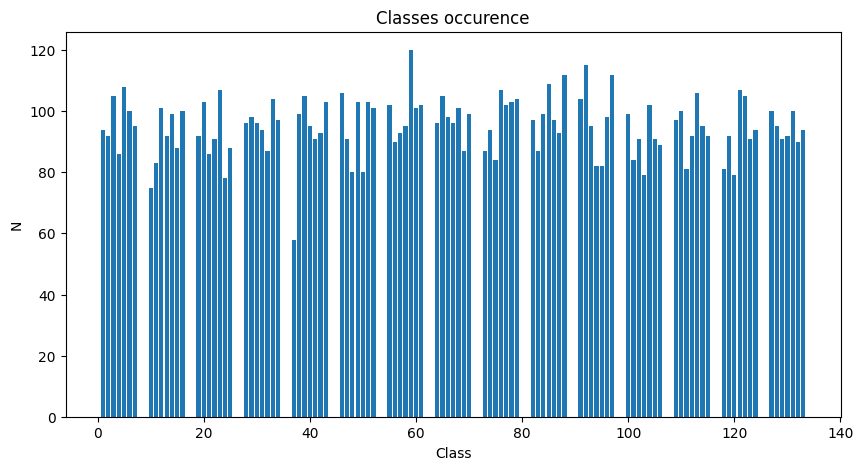

In [16]:
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Classes occurence')
plt.xlabel('Class')
plt.ylabel('N')
plt.show()

Define augmentations
-----

1. Random horizontal flip
2. Random vertical flip
3. Random 90° rotation (must correctly rotate orientation labels: up → right → down → left)
4. Random brightness/contrast
5. Gaussian noise
6. Random erasing

In [17]:
class Augmentation:
  """
  Augmentation types. An image can be modified according to one of those augmentations.
  """
  total = 6

  HORIZONTAL_FLIP = 0
  VERTICAL_FLIP = 1
  ROTATION = 2
  GAUSSIAN_NOISE = 3
  JITTER = 4
  ERASING = 5

class Column:
  """
  Label column indices for readability.
  """
  SQUARES = 0
  CIRCLES = 1
  UP = 2
  RIGHT = 3
  DOWN = 4
  LEFT = 5

class AugmentationTransform:
  def __init__(self, data, image_size, augmentation_probabilities: dict[Augmentation, float]):
      self.data = data


      self.augmentations = torch.zeros(size=(Augmentation.total,))
      for augmentation in range(Augmentation.total):
        print(f"Augmentation {augmentation} probability: {augmentation_probabilities.get(augmentation, 0.0)}")
        self.augmentations[augmentation] = augmentation_probabilities.get(augmentation, 0.0)
      self.image_size = image_size
      self.jitter = torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2)
      self.eraser = torchvision.transforms.RandomErasing(scale=(0.03, 0.06))
      self.gaussian_noise_level = 0.1

  def __call__(self, image, label):
      return self.augment_item(image.clone(), label.clone())

  def augment_item(self, image, label) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Randomly apply augmentations with a given probability each.
    """
    probs = torch.rand(6)
    if probs[0] < self.augmentations[Augmentation.HORIZONTAL_FLIP]:
      image, label = self.augmentation_flip(image, label, Augmentation.HORIZONTAL_FLIP)

    if probs[1] < self.augmentations[Augmentation.VERTICAL_FLIP]:
      image, label = self.augmentation_flip(image, label, Augmentation.VERTICAL_FLIP)

    if probs[2] < self.augmentations[Augmentation.ROTATION]:
      image, label = self.augmentation_rotation(image, label)

    if probs[3] < self.augmentations[Augmentation.GAUSSIAN_NOISE]:
      image, label = self.augmentation_gaussian(image, label, noise_level=self.gaussian_noise_level)

    if probs[4] < self.augmentations[Augmentation.JITTER]:
      image, label = self.augmentation_jitter(image, label)

    if probs[5] < self.augmentations[Augmentation.ERASING]:
      image, label = self.augmentation_erasing(image, label)
    return image, label

  def augmentation_flip(self, image: torch.Tensor, label: torch.Tensor, flip_direction: Augmentation) -> tuple:
    """
    Flip a subset of dataset images in-place.
    :param image: image data
    :param label: label data
    :param flip_direction: either horizontally or vertically
    :return: None
    """
    assert flip_direction == Augmentation.HORIZONTAL_FLIP or Augmentation.VERTICAL_FLIP, "Invalid flip direction"

    #alias for readability
    horizontal = (flip_direction == Augmentation.HORIZONTAL_FLIP)

    # flip
    image_shaped = image.reshape((self.image_size.x, self.image_size.y))
    if horizontal:
      image_flipped = torch.flip(image_shaped, dims=(1,)) # only the horizontal
    else: # vertical
      image_flipped = torch.flip(image_shaped, dims=(0,))
    image = image_flipped.reshape((self.image_size.x * self.image_size.y,))

    new_label = label.clone()
    # relabel
    if horizontal:
      new_label[Column.LEFT], new_label[Column.RIGHT] = label[Column.RIGHT], label[Column.LEFT]
    else: # vertical
      new_label[Column.UP], new_label[Column.DOWN] = label[Column.DOWN], label[Column.UP]
    return image, new_label

  def augmentation_rotation(self, image: torch.Tensor, label: torch.Tensor) -> tuple:
    """
    Rotate image either clockwise or counterclockwise with 50/50 probability.
    :param image: image data
    :param label: label data
    :return: tuple (image, label)
    """
    image_shaped = image.reshape((self.image_size.x, self.image_size.y))

    new_label = label.clone()
    clockwise = torch.randint(0, 2, size=(1,))[0] < 0.5
    if clockwise:
      image_rotated = torch.rot90(image_shaped, k=1, dims=(0, 1))
      new_label[Column.UP], new_label[Column.RIGHT], new_label[Column.DOWN], new_label[Column.LEFT] = \
        label[Column.LEFT], label[Column.UP], label[Column.RIGHT], label[Column.DOWN]
    else:
      image_rotated = torch.rot90(image_shaped, k=-1, dims=(0, 1))
      new_label[Column.UP], new_label[Column.LEFT], new_label[Column.DOWN], new_label[Column.RIGHT] = \
        label[Column.RIGHT], label[Column.UP], label[Column.LEFT], label[Column.DOWN]

    image = image_rotated.reshape((self.image_size.x * self.image_size.y,))
    return image, new_label

  def augmentation_gaussian(self, image: torch.Tensor, label: torch.Tensor, noise_level: float) -> tuple:
    """
    Add Gaussian noise to image.
    :param image: image data
    :param label: label data (unchanged)
    :param noise_level: pixel value variance
    :return: tuple (image, label)
    """
    noise = torch.normal(0., 1., size=image.shape)
    image = image + noise_level * noise
    image = torch.clamp(image, 0, 1)
    return image, label

  def augmentation_jitter(self, image: torch.Tensor, label: torch.Tensor) -> tuple:
    """
    Add random brightness/contrast changes to the image.
    :param image: image data
    :param label: label data (unchanged)
    :return: tuple (image, label)
    """
    image_shaped = image.reshape((1, self.image_size.x, self.image_size.y))
    image_jittered = self.jitter(image_shaped)
    image = image_jittered.reshape((self.image_size.x * self.image_size.y,))
    return image, label

  def augmentation_erasing(self, image: torch.Tensor, label: torch.Tensor) -> tuple:
    """
    Erase a random part of the image.
    :param image: image data
    :param label: label data (unchanged)
    :return: tuple (image, label)
    """
    image_shaped = image.reshape((1, self.image_size.x, self.image_size.y))
    imaged_erased = self.eraser(image_shaped)
    image = imaged_erased.reshape((self.image_size.x * self.image_size.y,))
    return image, label

Verify the dataset and augmentations visually
----

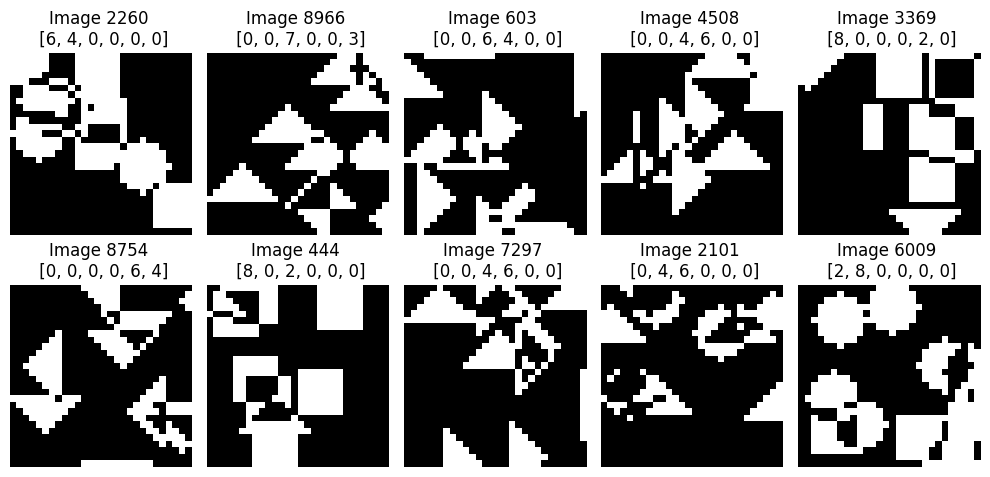

In [18]:
import matplotlib.pyplot as plt
import random

random_indices = random.sample(range(dataset.n_images), 10)

plt.figure(figsize=(10, 5))
for i, index in enumerate(random_indices):
    image_data = dataset.image_data[index].reshape((dataset.image_size.y, dataset.image_size.x))
    label = list([int(k) for k in dataset.y[index]])
    plt.subplot(2, 5, i + 1)
    plt.imshow(image_data.numpy(), cmap='gray')
    plt.title(f"Image {index} \n {label}")
    plt.axis('off')

plt.tight_layout()
plt.savefig("dataset_example_nonaugmented.jpg")
plt.show()

Augmentation 0 probability: 0.5
Augmentation 1 probability: 0.5
Augmentation 2 probability: 0.5
Augmentation 3 probability: 0.5
Augmentation 4 probability: 0.5
Augmentation 5 probability: 0.5


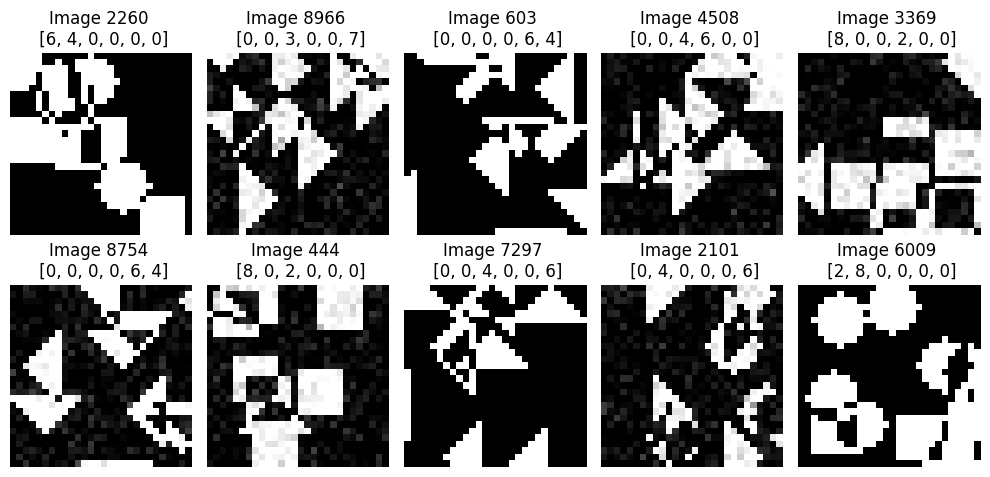

In [19]:
transform = AugmentationTransform(dataset,
                                  dataset.image_size,
                             {Augmentation.HORIZONTAL_FLIP: 0.5,
                              Augmentation.VERTICAL_FLIP: 0.5,
                              Augmentation.ROTATION: 0.5,
                              Augmentation.GAUSSIAN_NOISE: 0.5,
                              Augmentation.JITTER: 0.5,
                              Augmentation.ERASING: 0.5})

plt.figure(figsize=(10, 5))
for i, index in enumerate(random_indices):
    sample_image, sample_label = dataset.image_data[index], dataset.y[index]
    sample_image_augmented, sample_label_augmented = transform(sample_image, sample_label)
    image_data = sample_image_augmented.reshape((dataset.image_size.y, dataset.image_size.x))
    label = list([int(k) for k in sample_label_augmented])
    plt.subplot(2, 5, i + 1)
    plt.imshow(image_data.numpy(), cmap='gray')
    plt.title(f"Image {index} \n {label}")
    plt.axis('off')

plt.tight_layout()
plt.savefig("dataset_example_augmented.jpg")
plt.show()

In [20]:
sample_indices = [0, 100, 500, 1000, 5000]
for idx in sample_indices:
    label = dataset.y[idx]
    nonzero_count = (label > 0).sum().item()
    total = label.sum().item()
    print(f"Index {idx}: {label.tolist()}, nonzero={nonzero_count}, sum={total}")

Index 0: [0.0, 0.0, 4.0, 0.0, 6.0, 0.0], nonzero=2, sum=10.0
Index 100: [6.0, 0.0, 0.0, 0.0, 4.0, 0.0], nonzero=2, sum=10.0
Index 500: [0.0, 7.0, 3.0, 0.0, 0.0, 0.0], nonzero=2, sum=10.0
Index 1000: [0.0, 0.0, 0.0, 8.0, 2.0, 0.0], nonzero=2, sum=10.0
Index 5000: [5.0, 0.0, 0.0, 0.0, 5.0, 0.0], nonzero=2, sum=10.0


Set up the model
===

In [21]:
class ShapeClassifier(nn.Module):
    @staticmethod
    def create_feature_extractor():
        """
        Create the baseline feature extractor for the model.
        """
        feature_extractor = torch.nn.Sequential(
        nn.Conv2d(1, 8, 3, stride=1, padding=1), nn.ReLU(),
        nn.Conv2d(8, 16, 3, stride=1, padding=1), nn.ReLU(),
        nn.Conv2d(16, 32, 3, stride=1, padding=1), nn.ReLU(),
        nn.Conv2d(32, 64, 3, stride=1, padding=1), nn.ReLU(),
        nn.Flatten(start_dim=1),
        nn.Linear(64 * 28 * 28, 256), nn.ReLU())

        return feature_extractor

    def __init__(self, optimizer=torch.optim.Adam, lr=1e-3, epochs=100, batch_size=64, batch_size_val=1000, loss_coef=1):
        super().__init__()
        self.optimizer = optimizer
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.batch_size_val = batch_size_val

        self.loss_normalization_coef = loss_coef

        self.feature_extractor = self.create_feature_extractor()
        self.head_shapes = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256, 135))
        self.head_counts = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256, 6))

    def loss(self, logits_cls, target_shape, logits_counts, target_counts):
        return (torch.nn.functional.nll_loss(torch.log_softmax(logits_cls, dim=1), target_shape, reduction='mean') +
                self.loss_normalization_coef * torch.nn.functional.smooth_l1_loss(logits_counts, target_counts))

    def reg_loss(self, logits_counts, target_counts):
        return torch.nn.functional.smooth_l1_loss(logits_counts, target_counts)

    def forward(self, x):
        features = self.feature_extractor(x)
        logits_cls = self.head_shapes(features)
        logits_counts = self.head_counts(features)
        return logits_cls, logits_counts


In [22]:
class EarlyStopping:
    """
    Early stopping callback. Detects when the model stops improving and stops training.
    After that, loads the best model state to prevent overfitting.
    """
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)

Define the training loop
----

In [23]:
from collections import Counter
IMAGE_SIZE = dataset.image_size

def training_loop(model, optimizer, early_stopping, train_loader, test_loader, epochs, reg_loss_only=False):
    """
    Model training loop.
    :param model: model to train.
    :param optimizer: optimizer to use.
    :param early_stopping: early stopping callback. Can be None.
    :param train_loader: training data loader.
    :param test_loader: test data loader.
    :param epochs: number of epochs to train for. The actual number may be less is early stopping is defnined.
    :param reg_loss_only: whether to only use the regression loss or both classification and regression.
    :return: (train_losses, test_losses, accuracy) for classification or (train_losses, test_losses, (rmse, mae)) for regression
    """

    train_losses = []
    test_losses = []
    accuracies = []
    rmses = []
    maes = []
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        train_correct = 0
        train_total = 0

        for images, labels in tqdm.tqdm(train_loader):
            images = images.view(-1, 1, IMAGE_SIZE.x, IMAGE_SIZE.y).to(device)
            labels = labels.to(device)

            cls_goal = shapes_to_output_class(labels)
            cnt_goal = labels

            cls_y, cnt_y = model(images)

            if reg_loss_only:
              loss = model.reg_loss(cnt_y, cnt_goal)
            else:
              loss = model.loss(cls_y, cls_goal, cnt_y, cnt_goal)

            total_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_predictions = cls_y.argmax(dim=1)
            train_correct += (train_predictions == cls_goal).sum().item()
            train_total += labels.size(0)

        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images = images.view(-1, 1, 28, 28).to(device)
                labels = labels.to(device)

                target_counts = labels
                target_shape = shapes_to_output_class(labels)

                logits_cls, logits_counts = model(images)
                if reg_loss_only:
                  loss = model.reg_loss(logits_counts, target_counts)
                else:
                  loss = model.loss(logits_cls, target_shape, logits_counts, target_counts)

                test_loss += loss.item()

                # Accuracy
                predictions = logits_cls.argmax(dim=1)
                correct += (predictions == target_shape).sum().item()
                total += labels.size(0)

        cls_loss = torch.nn.functional.cross_entropy(logits_cls, target_shape)
        reg_loss = torch.nn.functional.smooth_l1_loss(logits_counts, target_counts)
        sum_loss = cls_loss + model.loss_normalization_coef * reg_loss

        train_losses.append(total_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))
        print(f"Cls: {cls_loss:.4f} | Reg: {reg_loss:.4f} | Total: {sum_loss:.4f}")
        print(f"Epoch {epoch+1}/{model.epochs} | "
              f"Train Loss: {total_loss/len(train_loader):.4f} | "
              f"Test Loss: {test_loss/len(test_loader):.4f}")
        if reg_loss_only:
          rmses.append(torch.sqrt(torch.mean((logits_counts - target_counts)**2)).item())
          maes.append(torch.mean(torch.abs(logits_counts - target_counts)).item())
          print(f"RMSE: {rmses[-1]:.4f} | MAE: {maes[-1]:.4f}")
        else:
          accuracies.append(100*correct/total)
          print(f"Train Acc: {100*train_correct/train_total:.2f}% | "
                f"Test Acc: {100*correct/total:.2f}%")

        if early_stopping is not None:
          early_stopping(sum_loss, model)
          if early_stopping.early_stop:
              print("Early stopping")
              break

    if early_stopping is not None:
      early_stopping.load_best_model(model)
    if reg_loss_only:
      return train_losses, test_losses, (rmses, maes)
    else:
      return train_losses, test_losses, accuracies

Load data
====

In [24]:
n_images = dataset.n_images
split_point = int(TRAIN_SIZE)

train_transform = AugmentationTransform(dataset,
                                  dataset.image_size,
                             {Augmentation.HORIZONTAL_FLIP: 0.3,
                              Augmentation.VERTICAL_FLIP: 0.3,
                              Augmentation.ROTATION: 0.25,
                              Augmentation.GAUSSIAN_NOISE: 0.1,
                              Augmentation.JITTER: 0.2,
                              Augmentation.ERASING: 0.2})
train_dataset = Dataset("data/", transform=train_transform, verbose=True)
# train_dataset = Dataset("data/", transform=None, verbose=True)
train_dataset.load()
train_subset = torch.utils.data.Subset(train_dataset, list(range(TRAIN_SIZE)))

test_dataset = Dataset("data/", transform=None, verbose=False)
test_dataset.image_data = train_dataset.image_data  # Share memory
test_dataset.y = train_dataset.y
test_dataset.n_images = train_dataset.n_images
test_dataset.image_size = train_dataset.image_size
test_subset = torch.utils.data.Subset(test_dataset, list(range(TRAIN_SIZE, n_images)))

Augmentation 0 probability: 0.3
Augmentation 1 probability: 0.3
Augmentation 2 probability: 0.25
Augmentation 3 probability: 0.1
Augmentation 4 probability: 0.2
Augmentation 5 probability: 0.2
Initialized in verbose mode
Reading all data
Reading labels
Labels:
            name  squares  circles  up  right  down  left
0  img_00000.png        0        0   4      0     6     0
1  img_00001.png        0        0   0      5     0     5
2  img_00002.png        0        0   8      0     2     0
3  img_00003.png        0        7   0      0     0     3
4  img_00004.png        0        0   3      0     0     7
Image shape is set to (28, 28) based on img_00000.png


100%|██████████| 10000/10000 [00:02<00:00, 3479.89it/s]

Data shape is torch.Size([10000, 784]) (10000 images of (28,28) size)


In [25]:
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_subset, batch_size=BATCH_SIZE_VALIDATION, shuffle=False)

In [26]:
print(f"Train loader size: {len(train_loader.dataset)}")
print(f"Test loader size: {len(test_loader.dataset)}")

Train loader size: 9000
Test loader size: 1000


In [27]:
# Verification
for i in range(5):
    label = dataset.y[i]
    class_idx = shapes_to_output_class(label)
    print(f"Label: {label.tolist()} → Class: {class_idx.item()}")
    print(f"Should be: {output_classes[class_idx]}")

Label: [0.0, 0.0, 4.0, 0.0, 6.0, 0.0] → Class: 93
Should be: tensor([2, 4, 4])
Label: [0.0, 0.0, 0.0, 5.0, 0.0, 5.0] → Class: 121
Should be: tensor([3, 5, 5])
Label: [0.0, 0.0, 8.0, 0.0, 2.0, 0.0] → Class: 97
Should be: tensor([2, 4, 8])
Label: [0.0, 7.0, 0.0, 0.0, 0.0, 3.0] → Class: 78
Should be: tensor([1, 5, 7])
Label: [0.0, 0.0, 3.0, 0.0, 0.0, 7.0] → Class: 101
Should be: tensor([2, 5, 3])


Train the model
===

Experiment 1: Classification-only
----

In [28]:
model_class = ShapeClassifier(loss_coef=0).to(device)
optimizer = torch.optim.Adam(model_class.parameters(), lr=1e-3)
early_stopping = EarlyStopping(patience=10, delta=0.01)

In [29]:
train_losses_class, test_losses_class, accuracies_class = training_loop(model_class, optimizer, early_stopping, train_loader, test_loader, EPOCHS, reg_loss_only=False)

100%|██████████| 141/141 [00:05<00:00, 27.00it/s]


Cls: 4.6770 | Reg: 1.5159 | Total: 4.6770
Epoch 1/100 | Train Loss: 4.7489 | Test Loss: 4.6770
Train Acc: 0.73% | Test Acc: 0.80%


100%|██████████| 141/141 [00:04<00:00, 34.07it/s]


Cls: 4.5444 | Reg: 1.5386 | Total: 4.5444
Epoch 2/100 | Train Loss: 4.6768 | Test Loss: 4.5444
Train Acc: 1.28% | Test Acc: 2.20%


100%|██████████| 141/141 [00:03<00:00, 40.15it/s]


Cls: 3.8628 | Reg: 1.6016 | Total: 3.8628
Epoch 3/100 | Train Loss: 4.2826 | Test Loss: 3.8628
Train Acc: 2.72% | Test Acc: 5.10%


100%|██████████| 141/141 [00:03<00:00, 40.81it/s]


Cls: 3.5050 | Reg: 1.6941 | Total: 3.5050
Epoch 4/100 | Train Loss: 3.9062 | Test Loss: 3.5050
Train Acc: 4.78% | Test Acc: 7.20%


100%|██████████| 141/141 [00:04<00:00, 31.86it/s]


Cls: 3.1125 | Reg: 1.7834 | Total: 3.1125
Epoch 5/100 | Train Loss: 3.6482 | Test Loss: 3.1125
Train Acc: 6.58% | Test Acc: 12.60%


100%|██████████| 141/141 [00:03<00:00, 39.76it/s]


Cls: 2.8736 | Reg: 1.7992 | Total: 2.8736
Epoch 6/100 | Train Loss: 3.3976 | Test Loss: 2.8736
Train Acc: 8.97% | Test Acc: 17.70%


100%|██████████| 141/141 [00:03<00:00, 39.77it/s]


Cls: 2.6402 | Reg: 1.9097 | Total: 2.6402
Epoch 7/100 | Train Loss: 3.1475 | Test Loss: 2.6402
Train Acc: 11.52% | Test Acc: 19.70%


100%|██████████| 141/141 [00:04<00:00, 29.97it/s]


Cls: 2.4833 | Reg: 1.9268 | Total: 2.4833
Epoch 8/100 | Train Loss: 2.9463 | Test Loss: 2.4833
Train Acc: 13.32% | Test Acc: 22.60%


100%|██████████| 141/141 [00:03<00:00, 38.32it/s]


Cls: 2.3009 | Reg: 1.9430 | Total: 2.3009
Epoch 9/100 | Train Loss: 2.7724 | Test Loss: 2.3009
Train Acc: 15.74% | Test Acc: 26.90%


100%|██████████| 141/141 [00:03<00:00, 40.09it/s]


Cls: 2.1931 | Reg: 1.9729 | Total: 2.1931
Epoch 10/100 | Train Loss: 2.6357 | Test Loss: 2.1931
Train Acc: 17.59% | Test Acc: 26.00%


100%|██████████| 141/141 [00:03<00:00, 40.26it/s]


Cls: 2.0841 | Reg: 1.9827 | Total: 2.0841
Epoch 11/100 | Train Loss: 2.5407 | Test Loss: 2.0841
Train Acc: 18.89% | Test Acc: 30.30%


100%|██████████| 141/141 [00:03<00:00, 35.72it/s]


Cls: 2.0135 | Reg: 2.0345 | Total: 2.0135
Epoch 12/100 | Train Loss: 2.4719 | Test Loss: 2.0135
Train Acc: 19.68% | Test Acc: 32.20%


100%|██████████| 141/141 [00:03<00:00, 41.12it/s]


Cls: 1.9204 | Reg: 2.0465 | Total: 1.9204
Epoch 13/100 | Train Loss: 2.3864 | Test Loss: 1.9204
Train Acc: 22.23% | Test Acc: 34.20%


100%|██████████| 141/141 [00:03<00:00, 41.30it/s]


Cls: 1.8408 | Reg: 2.0368 | Total: 1.8408
Epoch 14/100 | Train Loss: 2.3390 | Test Loss: 1.8408
Train Acc: 22.92% | Test Acc: 35.70%


100%|██████████| 141/141 [00:04<00:00, 34.44it/s]


Cls: 1.8286 | Reg: 2.0236 | Total: 1.8286
Epoch 15/100 | Train Loss: 2.3019 | Test Loss: 1.8286
Train Acc: 23.28% | Test Acc: 35.00%


100%|██████████| 141/141 [00:03<00:00, 40.84it/s]


Cls: 1.8470 | Reg: 2.0121 | Total: 1.8470
Epoch 16/100 | Train Loss: 2.2627 | Test Loss: 1.8470
Train Acc: 24.03% | Test Acc: 36.30%


100%|██████████| 141/141 [00:03<00:00, 40.63it/s]


Cls: 1.8262 | Reg: 2.0215 | Total: 1.8262
Epoch 17/100 | Train Loss: 2.2129 | Test Loss: 1.8262
Train Acc: 24.87% | Test Acc: 35.00%


100%|██████████| 141/141 [00:03<00:00, 37.54it/s]


Cls: 1.7502 | Reg: 1.9854 | Total: 1.7502
Epoch 18/100 | Train Loss: 2.1797 | Test Loss: 1.7502
Train Acc: 26.34% | Test Acc: 38.20%


100%|██████████| 141/141 [00:03<00:00, 37.03it/s]


Cls: 1.7294 | Reg: 2.0131 | Total: 1.7294
Epoch 19/100 | Train Loss: 2.1468 | Test Loss: 1.7294
Train Acc: 27.02% | Test Acc: 38.30%


100%|██████████| 141/141 [00:03<00:00, 40.43it/s]


Cls: 1.7357 | Reg: 2.0836 | Total: 1.7357
Epoch 20/100 | Train Loss: 2.1203 | Test Loss: 1.7357
Train Acc: 27.76% | Test Acc: 35.90%


100%|██████████| 141/141 [00:03<00:00, 40.84it/s]


Cls: 1.6785 | Reg: 2.0912 | Total: 1.6785
Epoch 21/100 | Train Loss: 2.0930 | Test Loss: 1.6785
Train Acc: 27.78% | Test Acc: 40.00%


100%|██████████| 141/141 [00:04<00:00, 34.73it/s]


Cls: 1.7507 | Reg: 2.0574 | Total: 1.7507
Epoch 22/100 | Train Loss: 2.0439 | Test Loss: 1.7507
Train Acc: 29.31% | Test Acc: 36.00%


100%|██████████| 141/141 [00:03<00:00, 36.15it/s]


Cls: 1.6885 | Reg: 2.0629 | Total: 1.6885
Epoch 23/100 | Train Loss: 2.0410 | Test Loss: 1.6885
Train Acc: 29.33% | Test Acc: 38.20%


100%|██████████| 141/141 [00:03<00:00, 39.99it/s]


Cls: 1.6997 | Reg: 2.0878 | Total: 1.6997
Epoch 24/100 | Train Loss: 2.0228 | Test Loss: 1.6997
Train Acc: 30.31% | Test Acc: 41.10%


100%|██████████| 141/141 [00:04<00:00, 34.45it/s]


Cls: 1.7005 | Reg: 2.0414 | Total: 1.7005
Epoch 25/100 | Train Loss: 2.0134 | Test Loss: 1.7005
Train Acc: 30.29% | Test Acc: 40.40%


100%|██████████| 141/141 [00:03<00:00, 40.65it/s]


Cls: 1.6335 | Reg: 2.0317 | Total: 1.6335
Epoch 26/100 | Train Loss: 1.9542 | Test Loss: 1.6335
Train Acc: 32.04% | Test Acc: 41.00%


100%|██████████| 141/141 [00:03<00:00, 41.77it/s]


Cls: 1.6304 | Reg: 2.0423 | Total: 1.6304
Epoch 27/100 | Train Loss: 1.9526 | Test Loss: 1.6304
Train Acc: 32.02% | Test Acc: 41.30%


100%|██████████| 141/141 [00:03<00:00, 37.43it/s]


Cls: 1.6265 | Reg: 2.0698 | Total: 1.6265
Epoch 28/100 | Train Loss: 1.9249 | Test Loss: 1.6265
Train Acc: 33.06% | Test Acc: 41.40%


100%|██████████| 141/141 [00:03<00:00, 38.42it/s]


Cls: 1.6503 | Reg: 2.0220 | Total: 1.6503
Epoch 29/100 | Train Loss: 1.9372 | Test Loss: 1.6503
Train Acc: 32.46% | Test Acc: 41.00%


100%|██████████| 141/141 [00:03<00:00, 41.22it/s]


Cls: 1.6069 | Reg: 2.0408 | Total: 1.6069
Epoch 30/100 | Train Loss: 1.9082 | Test Loss: 1.6069
Train Acc: 33.28% | Test Acc: 39.70%


100%|██████████| 141/141 [00:03<00:00, 40.03it/s]


Cls: 1.5990 | Reg: 2.0818 | Total: 1.5990
Epoch 31/100 | Train Loss: 1.8752 | Test Loss: 1.5990
Train Acc: 34.70% | Test Acc: 42.50%


100%|██████████| 141/141 [00:04<00:00, 31.81it/s]


Cls: 1.6094 | Reg: 2.0360 | Total: 1.6094
Epoch 32/100 | Train Loss: 1.8760 | Test Loss: 1.6094
Train Acc: 33.98% | Test Acc: 39.00%


100%|██████████| 141/141 [00:03<00:00, 40.58it/s]


Cls: 1.5863 | Reg: 2.0936 | Total: 1.5863
Epoch 33/100 | Train Loss: 1.8280 | Test Loss: 1.5863
Train Acc: 36.56% | Test Acc: 43.40%


100%|██████████| 141/141 [00:03<00:00, 40.88it/s]


Cls: 1.6208 | Reg: 2.0355 | Total: 1.6208
Epoch 34/100 | Train Loss: 1.7955 | Test Loss: 1.6208
Train Acc: 37.22% | Test Acc: 41.00%


100%|██████████| 141/141 [00:04<00:00, 34.90it/s]


Cls: 1.5689 | Reg: 2.0745 | Total: 1.5689
Epoch 35/100 | Train Loss: 1.8107 | Test Loss: 1.5689
Train Acc: 36.28% | Test Acc: 43.40%


100%|██████████| 141/141 [00:03<00:00, 39.94it/s]


Cls: 1.6551 | Reg: 2.0592 | Total: 1.6551
Epoch 36/100 | Train Loss: 1.7816 | Test Loss: 1.6551
Train Acc: 37.23% | Test Acc: 40.80%


100%|██████████| 141/141 [00:03<00:00, 40.81it/s]


Cls: 1.6544 | Reg: 2.1029 | Total: 1.6544
Epoch 37/100 | Train Loss: 1.7835 | Test Loss: 1.6544
Train Acc: 37.46% | Test Acc: 40.70%


100%|██████████| 141/141 [00:03<00:00, 36.43it/s]


Cls: 1.5810 | Reg: 2.0955 | Total: 1.5810
Epoch 38/100 | Train Loss: 1.7564 | Test Loss: 1.5810
Train Acc: 38.64% | Test Acc: 43.10%


100%|██████████| 141/141 [00:03<00:00, 37.81it/s]


Cls: 1.6107 | Reg: 2.0755 | Total: 1.6107
Epoch 39/100 | Train Loss: 1.7181 | Test Loss: 1.6107
Train Acc: 40.46% | Test Acc: 43.10%


100%|██████████| 141/141 [00:03<00:00, 40.85it/s]


Cls: 1.5897 | Reg: 2.0758 | Total: 1.5897
Epoch 40/100 | Train Loss: 1.7083 | Test Loss: 1.5897
Train Acc: 40.42% | Test Acc: 42.80%


100%|██████████| 141/141 [00:03<00:00, 40.77it/s]


Cls: 1.5604 | Reg: 2.0946 | Total: 1.5604
Epoch 41/100 | Train Loss: 1.6940 | Test Loss: 1.5604
Train Acc: 41.11% | Test Acc: 42.20%


100%|██████████| 141/141 [00:04<00:00, 34.69it/s]


Cls: 1.5640 | Reg: 2.0969 | Total: 1.5640
Epoch 42/100 | Train Loss: 1.6871 | Test Loss: 1.5640
Train Acc: 40.84% | Test Acc: 44.70%


100%|██████████| 141/141 [00:03<00:00, 39.75it/s]


Cls: 1.5674 | Reg: 2.0873 | Total: 1.5674
Epoch 43/100 | Train Loss: 1.6769 | Test Loss: 1.5674
Train Acc: 41.39% | Test Acc: 44.30%


100%|██████████| 141/141 [00:03<00:00, 41.03it/s]


Cls: 1.6260 | Reg: 2.0491 | Total: 1.6260
Epoch 44/100 | Train Loss: 1.6579 | Test Loss: 1.6260
Train Acc: 42.44% | Test Acc: 40.10%


100%|██████████| 141/141 [00:04<00:00, 35.24it/s]

Cls: 1.6485 | Reg: 2.1006 | Total: 1.6485
Epoch 45/100 | Train Loss: 1.6593 | Test Loss: 1.6485
Train Acc: 42.42% | Test Acc: 40.90%
Early stopping


Experiment 2: Regression-only
---

In [30]:
model_reg = ShapeClassifier(loss_coef=1).to(device)
optimizer = torch.optim.Adam(model_reg.parameters(), lr=1e-3)
early_stopping = EarlyStopping(patience=10, delta=0.01)

In [31]:
model_reg(dataset.__getitem__(54)[0].view(-1, 1, IMAGE_SIZE.x, IMAGE_SIZE.y).to(device))[1]

tensor([[ 0.0650,  0.0253, -0.0056, -0.0519,  0.0684, -0.0046]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [32]:
train_losses_reg, test_losses_reg, metrics_reg = training_loop(model_reg, optimizer, early_stopping, train_loader, test_loader, EPOCHS, reg_loss_only=True)
rmse, mae = metrics_reg

100%|██████████| 141/141 [00:03<00:00, 40.67it/s]


Cls: 4.9370 | Reg: 1.3615 | Total: 6.2984
Epoch 1/100 | Train Loss: 1.4177 | Test Loss: 1.3615


100%|██████████| 141/141 [00:03<00:00, 41.11it/s]


Cls: 5.0276 | Reg: 1.0908 | Total: 6.1184
Epoch 2/100 | Train Loss: 1.2778 | Test Loss: 1.0908


100%|██████████| 141/141 [00:03<00:00, 36.56it/s]


Cls: 5.1069 | Reg: 0.7602 | Total: 5.8671
Epoch 3/100 | Train Loss: 1.0956 | Test Loss: 0.7602


100%|██████████| 141/141 [00:03<00:00, 40.25it/s]


Cls: 5.1453 | Reg: 0.5372 | Total: 5.6825
Epoch 4/100 | Train Loss: 0.9439 | Test Loss: 0.5372


100%|██████████| 141/141 [00:03<00:00, 41.20it/s]


Cls: 5.1382 | Reg: 0.4610 | Total: 5.5991
Epoch 5/100 | Train Loss: 0.8389 | Test Loss: 0.4610


100%|██████████| 141/141 [00:03<00:00, 41.36it/s]


Cls: 5.1017 | Reg: 0.4732 | Total: 5.5749
Epoch 6/100 | Train Loss: 0.8040 | Test Loss: 0.4732


100%|██████████| 141/141 [00:03<00:00, 36.23it/s]


Cls: 5.1078 | Reg: 0.4131 | Total: 5.5209
Epoch 7/100 | Train Loss: 0.7712 | Test Loss: 0.4131


100%|██████████| 141/141 [00:03<00:00, 41.50it/s]


Cls: 5.1339 | Reg: 0.3863 | Total: 5.5203
Epoch 8/100 | Train Loss: 0.7657 | Test Loss: 0.3863


100%|██████████| 141/141 [00:03<00:00, 41.48it/s]


Cls: 5.1095 | Reg: 0.3743 | Total: 5.4838
Epoch 9/100 | Train Loss: 0.7439 | Test Loss: 0.3743


100%|██████████| 141/141 [00:03<00:00, 35.31it/s]


Cls: 5.0788 | Reg: 0.4422 | Total: 5.5210
Epoch 10/100 | Train Loss: 0.7415 | Test Loss: 0.4422


100%|██████████| 141/141 [00:03<00:00, 41.33it/s]


Cls: 5.0739 | Reg: 0.4137 | Total: 5.4876
Epoch 11/100 | Train Loss: 0.7311 | Test Loss: 0.4137


100%|██████████| 141/141 [00:03<00:00, 41.95it/s]


Cls: 5.0916 | Reg: 0.3791 | Total: 5.4707
Epoch 12/100 | Train Loss: 0.7296 | Test Loss: 0.3791


100%|██████████| 141/141 [00:03<00:00, 39.68it/s]


Cls: 5.0896 | Reg: 0.3849 | Total: 5.4745
Epoch 13/100 | Train Loss: 0.7329 | Test Loss: 0.3849


100%|██████████| 141/141 [00:03<00:00, 36.75it/s]


Cls: 5.1035 | Reg: 0.3512 | Total: 5.4547
Epoch 14/100 | Train Loss: 0.7145 | Test Loss: 0.3512


100%|██████████| 141/141 [00:03<00:00, 41.85it/s]


Cls: 5.0989 | Reg: 0.3673 | Total: 5.4663
Epoch 15/100 | Train Loss: 0.7071 | Test Loss: 0.3673


100%|██████████| 141/141 [00:03<00:00, 41.34it/s]


Cls: 5.0815 | Reg: 0.3573 | Total: 5.4388
Epoch 16/100 | Train Loss: 0.7087 | Test Loss: 0.3573


100%|██████████| 141/141 [00:03<00:00, 35.80it/s]


Cls: 5.0989 | Reg: 0.3393 | Total: 5.4382
Epoch 17/100 | Train Loss: 0.7077 | Test Loss: 0.3393


100%|██████████| 141/141 [00:03<00:00, 41.45it/s]


Cls: 5.0789 | Reg: 0.3568 | Total: 5.4357
Epoch 18/100 | Train Loss: 0.7062 | Test Loss: 0.3568


100%|██████████| 141/141 [00:03<00:00, 41.04it/s]


Cls: 5.0920 | Reg: 0.3331 | Total: 5.4251
Epoch 19/100 | Train Loss: 0.7070 | Test Loss: 0.3331


100%|██████████| 141/141 [00:03<00:00, 38.83it/s]


Cls: 5.0701 | Reg: 0.3968 | Total: 5.4668
Epoch 20/100 | Train Loss: 0.6916 | Test Loss: 0.3968


100%|██████████| 141/141 [00:03<00:00, 37.86it/s]


Cls: 5.0538 | Reg: 0.4259 | Total: 5.4797
Epoch 21/100 | Train Loss: 0.6970 | Test Loss: 0.4259


100%|██████████| 141/141 [00:03<00:00, 41.27it/s]


Cls: 5.0631 | Reg: 0.3612 | Total: 5.4243
Epoch 22/100 | Train Loss: 0.7013 | Test Loss: 0.3612


100%|██████████| 141/141 [00:03<00:00, 41.88it/s]


Cls: 5.0625 | Reg: 0.3556 | Total: 5.4181
Epoch 23/100 | Train Loss: 0.6911 | Test Loss: 0.3556


100%|██████████| 141/141 [00:04<00:00, 35.16it/s]


Cls: 5.0674 | Reg: 0.3494 | Total: 5.4169
Epoch 24/100 | Train Loss: 0.6901 | Test Loss: 0.3494


100%|██████████| 141/141 [00:03<00:00, 41.54it/s]


Cls: 5.0558 | Reg: 0.3534 | Total: 5.4092
Epoch 25/100 | Train Loss: 0.6860 | Test Loss: 0.3534


100%|██████████| 141/141 [00:03<00:00, 41.50it/s]


Cls: 5.0561 | Reg: 0.3787 | Total: 5.4349
Epoch 26/100 | Train Loss: 0.6812 | Test Loss: 0.3787


100%|██████████| 141/141 [00:03<00:00, 35.98it/s]


Cls: 5.0572 | Reg: 0.3505 | Total: 5.4077
Epoch 27/100 | Train Loss: 0.6670 | Test Loss: 0.3505


100%|██████████| 141/141 [00:03<00:00, 40.07it/s]


Cls: 5.0505 | Reg: 0.3526 | Total: 5.4031
Epoch 28/100 | Train Loss: 0.6681 | Test Loss: 0.3526


100%|██████████| 141/141 [00:03<00:00, 41.02it/s]


Cls: 5.0566 | Reg: 0.3935 | Total: 5.4500
Epoch 29/100 | Train Loss: 0.6724 | Test Loss: 0.3935


100%|██████████| 141/141 [00:03<00:00, 40.32it/s]


Cls: 5.0588 | Reg: 0.3523 | Total: 5.4110
Epoch 30/100 | Train Loss: 0.6685 | Test Loss: 0.3523


100%|██████████| 141/141 [00:03<00:00, 35.32it/s]


Cls: 5.0498 | Reg: 0.3805 | Total: 5.4303
Epoch 31/100 | Train Loss: 0.6684 | Test Loss: 0.3805


100%|██████████| 141/141 [00:03<00:00, 41.44it/s]


Cls: 5.0443 | Reg: 0.3658 | Total: 5.4101
Epoch 32/100 | Train Loss: 0.6634 | Test Loss: 0.3658


100%|██████████| 141/141 [00:07<00:00, 18.29it/s]


Cls: 5.0564 | Reg: 0.3498 | Total: 5.4062
Epoch 33/100 | Train Loss: 0.6753 | Test Loss: 0.3498


100%|██████████| 141/141 [00:04<00:00, 34.42it/s]


Cls: 5.0408 | Reg: 0.3861 | Total: 5.4269
Epoch 34/100 | Train Loss: 0.6554 | Test Loss: 0.3861


100%|██████████| 141/141 [00:04<00:00, 32.01it/s]

Cls: 5.0505 | Reg: 0.3618 | Total: 5.4123
Epoch 35/100 | Train Loss: 0.6579 | Test Loss: 0.3618
Early stopping


Experiment 3: Multitask
----

In [33]:
model = ShapeClassifier(loss_coef=6).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
early_stopping = EarlyStopping(patience=10, delta=0.01)
model

ShapeClassifier(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=50176, out_features=256, bias=True)
    (10): ReLU()
  )
  (head_shapes): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=256, out_features=135, bias=True)
  )
  (head_counts): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=256, out_features=6, bias=True)
  )
)

In [34]:
train_losses_joint, test_losses_joint, accuracies_joint = training_loop(model, optimizer, early_stopping, train_loader, test_loader, EPOCHS, reg_loss_only=False)

100%|██████████| 141/141 [00:04<00:00, 34.07it/s]


Cls: 4.3657 | Reg: 1.2756 | Total: 12.0191
Epoch 1/100 | Train Loss: 13.1220 | Test Loss: 12.0191
Train Acc: 1.14% | Test Acc: 2.20%


100%|██████████| 141/141 [00:03<00:00, 40.72it/s]


Cls: 3.3115 | Reg: 0.9413 | Total: 8.9592
Epoch 2/100 | Train Loss: 10.8284 | Test Loss: 8.9592
Train Acc: 4.86% | Test Acc: 9.40%


100%|██████████| 141/141 [00:03<00:00, 40.14it/s]


Cls: 2.8418 | Reg: 0.8149 | Total: 7.7312
Epoch 3/100 | Train Loss: 8.9459 | Test Loss: 7.7312
Train Acc: 9.21% | Test Acc: 13.70%


100%|██████████| 141/141 [00:05<00:00, 26.21it/s]


Cls: 2.4839 | Reg: 0.5260 | Total: 5.6399
Epoch 4/100 | Train Loss: 8.1418 | Test Loss: 5.6399
Train Acc: 11.79% | Test Acc: 21.00%


100%|██████████| 141/141 [00:03<00:00, 38.77it/s]


Cls: 2.3029 | Reg: 0.4677 | Total: 5.1090
Epoch 5/100 | Train Loss: 7.5380 | Test Loss: 5.1090
Train Acc: 16.02% | Test Acc: 25.00%


100%|██████████| 141/141 [00:03<00:00, 40.33it/s]


Cls: 2.1768 | Reg: 0.4301 | Total: 4.7575
Epoch 6/100 | Train Loss: 7.2845 | Test Loss: 4.7575
Train Acc: 17.39% | Test Acc: 29.40%


100%|██████████| 141/141 [00:03<00:00, 37.02it/s]


Cls: 2.1246 | Reg: 0.4325 | Total: 4.7198
Epoch 7/100 | Train Loss: 7.1417 | Test Loss: 4.7198
Train Acc: 19.12% | Test Acc: 29.50%


100%|██████████| 141/141 [00:03<00:00, 37.34it/s]


Cls: 2.1153 | Reg: 0.4359 | Total: 4.7310
Epoch 8/100 | Train Loss: 6.9520 | Test Loss: 4.7310
Train Acc: 20.26% | Test Acc: 29.60%


100%|██████████| 141/141 [00:03<00:00, 39.99it/s]


Cls: 2.0120 | Reg: 0.3893 | Total: 4.3476
Epoch 9/100 | Train Loss: 6.8049 | Test Loss: 4.3476
Train Acc: 21.52% | Test Acc: 31.70%


100%|██████████| 141/141 [00:04<00:00, 30.36it/s]


Cls: 1.9854 | Reg: 0.3833 | Total: 4.2852
Epoch 10/100 | Train Loss: 6.7014 | Test Loss: 4.2852
Train Acc: 22.21% | Test Acc: 31.90%


100%|██████████| 141/141 [00:03<00:00, 37.18it/s]


Cls: 1.9790 | Reg: 0.3933 | Total: 4.3391
Epoch 11/100 | Train Loss: 6.8331 | Test Loss: 4.3391
Train Acc: 22.18% | Test Acc: 34.20%


100%|██████████| 141/141 [00:03<00:00, 40.25it/s]


Cls: 1.9358 | Reg: 0.3743 | Total: 4.1816
Epoch 12/100 | Train Loss: 6.6814 | Test Loss: 4.1816
Train Acc: 22.77% | Test Acc: 33.20%


100%|██████████| 141/141 [00:03<00:00, 41.11it/s]


Cls: 1.9459 | Reg: 0.3734 | Total: 4.1862
Epoch 13/100 | Train Loss: 6.5894 | Test Loss: 4.1862
Train Acc: 23.68% | Test Acc: 35.40%


100%|██████████| 141/141 [00:04<00:00, 34.96it/s]


Cls: 1.8679 | Reg: 0.3372 | Total: 3.8910
Epoch 14/100 | Train Loss: 6.5986 | Test Loss: 3.8910
Train Acc: 23.70% | Test Acc: 32.90%


100%|██████████| 141/141 [00:03<00:00, 39.85it/s]


Cls: 1.9510 | Reg: 0.3700 | Total: 4.1709
Epoch 15/100 | Train Loss: 6.5221 | Test Loss: 4.1709
Train Acc: 24.42% | Test Acc: 34.60%


100%|██████████| 141/141 [00:03<00:00, 40.86it/s]


Cls: 1.8216 | Reg: 0.3438 | Total: 3.8844
Epoch 16/100 | Train Loss: 6.4272 | Test Loss: 3.8844
Train Acc: 24.84% | Test Acc: 37.60%


100%|██████████| 141/141 [00:04<00:00, 30.78it/s]


Cls: 1.8198 | Reg: 0.3617 | Total: 3.9901
Epoch 17/100 | Train Loss: 6.4226 | Test Loss: 3.9901
Train Acc: 25.09% | Test Acc: 38.40%


100%|██████████| 141/141 [00:03<00:00, 36.33it/s]


Cls: 1.8188 | Reg: 0.3472 | Total: 3.9019
Epoch 18/100 | Train Loss: 6.4332 | Test Loss: 3.9019
Train Acc: 25.60% | Test Acc: 40.80%


100%|██████████| 141/141 [00:03<00:00, 40.61it/s]


Cls: 1.8834 | Reg: 0.3794 | Total: 4.1599
Epoch 19/100 | Train Loss: 6.3360 | Test Loss: 4.1599
Train Acc: 25.92% | Test Acc: 34.00%


100%|██████████| 141/141 [00:03<00:00, 37.14it/s]


Cls: 1.8459 | Reg: 0.3650 | Total: 4.0358
Epoch 20/100 | Train Loss: 6.3519 | Test Loss: 4.0358
Train Acc: 26.24% | Test Acc: 37.00%


100%|██████████| 141/141 [00:03<00:00, 37.39it/s]


Cls: 1.7705 | Reg: 0.3448 | Total: 3.8395
Epoch 21/100 | Train Loss: 6.2965 | Test Loss: 3.8395
Train Acc: 26.18% | Test Acc: 40.20%


100%|██████████| 141/141 [00:03<00:00, 40.56it/s]


Cls: 1.7122 | Reg: 0.3131 | Total: 3.5906
Epoch 22/100 | Train Loss: 6.2347 | Test Loss: 3.5906
Train Acc: 26.83% | Test Acc: 39.70%


100%|██████████| 141/141 [00:05<00:00, 26.39it/s]


Cls: 1.7437 | Reg: 0.3192 | Total: 3.6591
Epoch 23/100 | Train Loss: 6.1892 | Test Loss: 3.6591
Train Acc: 28.53% | Test Acc: 40.40%


100%|██████████| 141/141 [00:04<00:00, 31.98it/s]


Cls: 1.7409 | Reg: 0.3369 | Total: 3.7621
Epoch 24/100 | Train Loss: 6.2284 | Test Loss: 3.7621
Train Acc: 28.08% | Test Acc: 38.80%


100%|██████████| 141/141 [00:03<00:00, 36.46it/s]


Cls: 1.7741 | Reg: 0.3567 | Total: 3.9144
Epoch 25/100 | Train Loss: 6.2036 | Test Loss: 3.9144
Train Acc: 28.34% | Test Acc: 37.40%


100%|██████████| 141/141 [00:05<00:00, 24.16it/s]


Cls: 1.7280 | Reg: 0.3252 | Total: 3.6791
Epoch 26/100 | Train Loss: 6.1699 | Test Loss: 3.6791
Train Acc: 28.14% | Test Acc: 39.40%


100%|██████████| 141/141 [00:04<00:00, 30.80it/s]


Cls: 1.7465 | Reg: 0.3336 | Total: 3.7480
Epoch 27/100 | Train Loss: 6.2126 | Test Loss: 3.7480
Train Acc: 27.72% | Test Acc: 39.30%


100%|██████████| 141/141 [00:04<00:00, 33.00it/s]


Cls: 1.7087 | Reg: 0.3300 | Total: 3.6887
Epoch 28/100 | Train Loss: 6.1254 | Test Loss: 3.6887
Train Acc: 28.40% | Test Acc: 40.00%


100%|██████████| 141/141 [00:04<00:00, 34.48it/s]


Cls: 1.7226 | Reg: 0.3412 | Total: 3.7697
Epoch 29/100 | Train Loss: 6.0706 | Test Loss: 3.7697
Train Acc: 29.51% | Test Acc: 37.90%


100%|██████████| 141/141 [00:03<00:00, 40.27it/s]


Cls: 1.7121 | Reg: 0.3433 | Total: 3.7719
Epoch 30/100 | Train Loss: 6.0929 | Test Loss: 3.7719
Train Acc: 29.26% | Test Acc: 40.50%


100%|██████████| 141/141 [00:03<00:00, 40.28it/s]


Cls: 1.7048 | Reg: 0.3342 | Total: 3.7100
Epoch 31/100 | Train Loss: 5.9436 | Test Loss: 3.7100
Train Acc: 29.83% | Test Acc: 40.50%


100%|██████████| 141/141 [00:04<00:00, 35.23it/s]

Cls: 1.6614 | Reg: 0.3332 | Total: 3.6605
Epoch 32/100 | Train Loss: 6.0014 | Test Loss: 3.6605
Train Acc: 30.28% | Test Acc: 42.40%
Early stopping


Evaluate the model
===

### (b) **Regression (6-D counts)**

* RMSE per class and overall
* MAE per class and overall

Also plot:

* Training and validation losses
* Validation accuracy and RMSE over epochs


In [35]:
def graph_loss_class(train_losses, test_losses, accuracies, graph_name):
    plt.plot(train_losses, label="Train")
    plt.plot(test_losses, label="Test")
    plt.plot(accuracies, label="Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(graph_name)
    plt.show()

def graph_loss_reg(train_losses, test_losses, rmse, mae, graph_name):
    plt.plot(train_losses, label="Train")
    plt.plot(test_losses, label="Test")
    plt.plot(rmse, label="RMSE")
    plt.plot(mae, label="MAE")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(graph_name)
    plt.show()

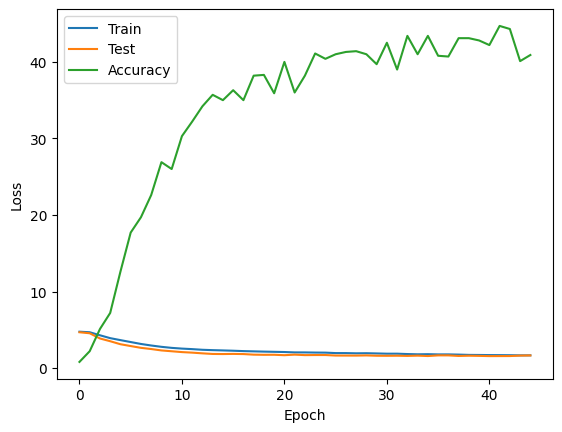

In [36]:
graph_loss_class(train_losses_class, test_losses_class, accuracies_class, "loss_classification_only.jpg")

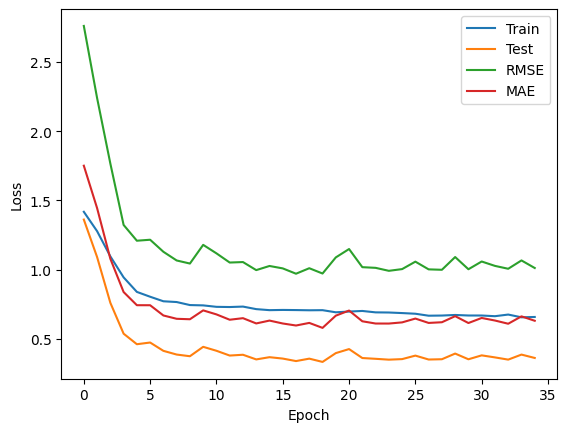

In [37]:
graph_loss_reg(train_losses_reg, test_losses_reg, rmse, mae, "loss_regression_only.jpg")

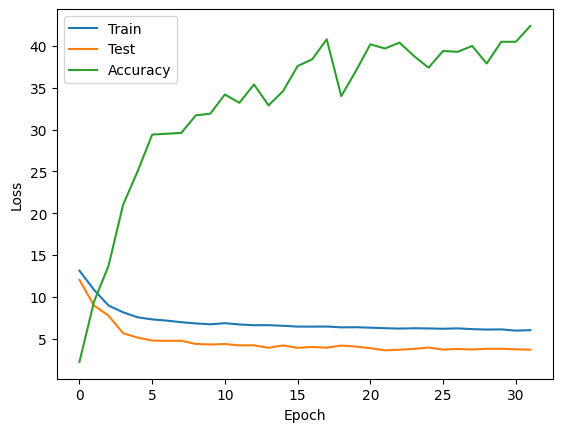

In [38]:
graph_loss_class(train_losses_joint, test_losses_joint, accuracies_joint, "loss.jpg")

In [39]:
# Torchmetrics have trouble being imported; using a manual fallback.
def calculate_metrics(predictions, targets, num_classes):
    precision_per_class = []
    recall_per_class = []
    f1_per_class = []

    for c in range(num_classes):
        if not torch.any(targets == c):
          continue
        #print(len(predictions), len(targets))
        #print(predictions == c)
        tp = ((predictions == c) & (targets == c)).sum().float()
        fp = ((predictions == c) & (targets != c)).sum().float()
        fn = ((predictions != c) & (targets == c)).sum().float()

        precision = tp / (tp + fp) if (tp + fp) > 0 else torch.tensor(0.0)
        recall = tp / (tp + fn) if (tp + fn) > 0 else torch.tensor(0.0)
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else torch.tensor(0.0)

        precision_per_class.append(precision)
        recall_per_class.append(recall)
        f1_per_class.append(f1)

    return (torch.stack(precision_per_class).mean().item(),
            torch.stack(recall_per_class).mean().item(),
            torch.stack(f1_per_class).mean().item())

def evaluate_classification_model(model, test_loader):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    num_classes = len(class_counts)
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.view(-1, 1, 28, 28).to(device)
            labels = labels.to(device)

            target_counts = labels
            target_shape = shapes_to_output_class(labels)

            logits_cls, logits_counts = model(images)
            loss = model.loss(logits_cls, target_shape, logits_counts, target_counts)

            test_loss += loss.item()

            # Accuracy
            predictions = logits_cls.argmax(dim=1)
            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(target_shape.cpu().numpy())
            correct += (predictions == target_shape).sum().item()
            total += labels.size(0)

    cls_loss = torch.nn.functional.cross_entropy(logits_cls, target_shape)
    reg_loss = torch.nn.functional.smooth_l1_loss(logits_counts, target_counts)
    sum_loss = cls_loss + model.loss_normalization_coef * reg_loss

    precision, recall, f1 = calculate_metrics(torch.Tensor(all_predictions), torch.Tensor(all_targets), num_classes)

    print(f"Cls: {cls_loss:.4f} | Reg: {reg_loss:.4f} | Total: {sum_loss:.4f}")
    print(f"Test Loss: {test_loss/len(test_loader):.4f} | "
          f"Test Acc: {100*correct/total:.2f}% | "
          f"Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")

In [40]:
evaluate_classification_model(model_class, test_loader)
evaluate_classification_model(model, test_loader)

Cls: 1.6485 | Reg: 2.1006 | Total: 1.6485
Test Loss: 1.6485 | Test Acc: 40.90% | Precision: 0.4407 | Recall: 0.4213 | F1: 0.3812
Cls: 1.6614 | Reg: 0.3332 | Total: 3.6605
Test Loss: 3.6605 | Test Acc: 42.40% | Precision: 0.4088 | Recall: 0.4316 | F1: 0.3714


Analyze the failure modes
---

In [41]:
def analyze_features():
    model.eval()
    all_features = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.view(-1, 1, 28, 28).to(device)
            features = model.feature_extractor(images)
            all_features.append(features.cpu())
            all_labels.append(labels)

    features = torch.cat(all_features)
    labels = torch.cat(all_labels)

    # Check feature statistics
    print(f"Feature mean: {features.mean():.4f}")
    print(f"Feature std: {features.std():.4f}")
    print(f"Dead neurons (std < 0.01): {(features.std(dim=0) < 0.01).sum()}/256")
    print(f"Feature rank (approx): {torch.linalg.matrix_rank(features[:1000])}/256")

analyze_features()

Feature mean: 0.4622
Feature std: 1.5213
Dead neurons (std < 0.01): 175/256
Feature rank (approx): 81/256


In [42]:
def analyze_predictions():
    model.eval()
    shape_correct = 0
    count_correct = 0
    both_correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.view(-1, 1, 28, 28).to(device)
            labels = labels.to(device)

            logits_cls, _ = model(images)
            preds = logits_cls.argmax(dim=1)
            targets = shapes_to_output_class(labels)

            for i in range(len(preds)):
                pred_class = output_classes[preds[i]]
                true_class = output_classes[targets[i]]

                # Check if shape types match (first two elements)
                if pred_class[0] == true_class[0] and pred_class[1] == true_class[1]:
                    shape_correct += 1

                # Check if count matches (third element)
                if pred_class[2] == true_class[2]:
                    count_correct += 1

                if preds[i] == targets[i]:
                    both_correct += 1

                total += 1

    print(f"Shape pair accuracy: {100*shape_correct/total:.2f}%")
    print(f"Count accuracy: {100*count_correct/total:.2f}%")
    print(f"Both correct: {100*both_correct/total:.2f}%")
    print(f"\nIf independent: {100*(shape_correct/total)*(count_correct/total):.2f}%")

analyze_predictions()

Shape pair accuracy: 91.30%
Count accuracy: 45.30%
Both correct: 42.40%

If independent: 41.36%


In [43]:
# Analyze errors by shape pair
from collections import defaultdict

errors_by_shapes = defaultdict(list)
shape_names = ["circle", "square", "t_up", "t_down", "t_left", "t_right"]
shape_pairs_matrix = torch.zeros((len(shape_names), len(shape_names)))
confusion_matrix = torch.zeros((len(output_classes), len(output_classes)))

with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(-1, 1, 28, 28).to(device)
        labels = labels.to(device)

        logits_cls, _ = model(images)
        preds = logits_cls.argmax(dim=1)
        targets = shapes_to_output_class(labels)

        for i in range(len(preds)):
            if preds[i] != targets[i]:
                # Get which shapes are in this sample
                true_class = output_classes[targets[i]]
                pred_class = output_classes[preds[i]]
                shapes = (int(true_class[0]), int(true_class[1]))
                errors_by_shapes[shapes].append((true_class, pred_class))
                shape_pairs_matrix[true_class[0], true_class[1]] += 1
                confusion_matrix[targets[i], preds[i]] += 1

# Find shape pairs with most errors
for shapes, errors in sorted(errors_by_shapes.items(), key=lambda x: len(x[1]), reverse=True)[:5]:
    print(f"\nShape pair ({shape_names[shapes[0]]}, {shape_names[shapes[1]]}): {len(errors)} errors")
    #print(f"Example errors: {errors[:3]}")


Shape pair (circle, t_left): 47 errors

Shape pair (t_down, t_right): 46 errors

Shape pair (square, t_down): 45 errors

Shape pair (t_left, t_right): 43 errors

Shape pair (t_up, t_right): 42 errors


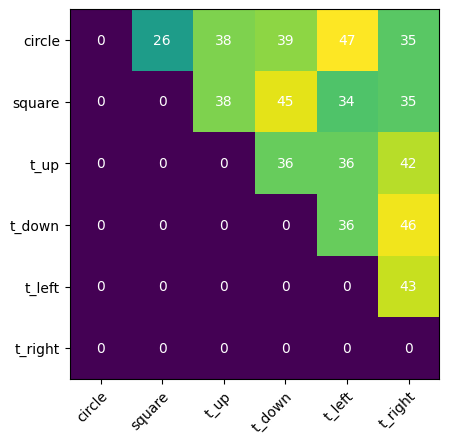

In [44]:
fig, ax = plt.subplots()
im = ax.imshow(shape_pairs_matrix, cmap='hot', interpolation='nearest')

ax.set_xticks(range(len(shape_names)), labels=shape_names,
              rotation=45, ha="right", rotation_mode="anchor")
ax.set_yticks(range(len(shape_names)), labels=shape_names)

for i in range(len(shape_names)):
    for j in range(len(shape_names)):
        text = ax.text(j, i, int(shape_pairs_matrix[i, j]),
                       ha="center", va="center", color="w")


plt.imshow(shape_pairs_matrix)
plt.show()

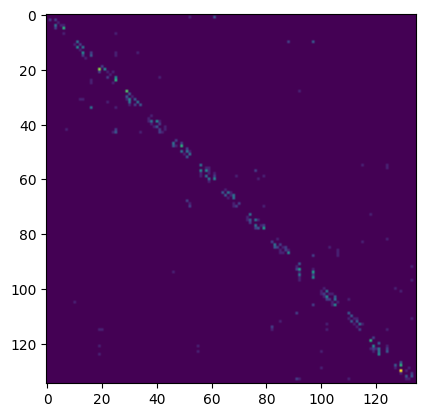

In [45]:
fig, ax = plt.subplots()
im = ax.imshow(confusion_matrix, cmap='hot', interpolation='nearest')


plt.imshow(confusion_matrix)
plt.show()